# Accessing and plotting Digital Earth Africa ALOS PALSAR data

Digital Earth Africa data can be accessed, inspected, and analysed in a range of computing environments. This notebook demonstrates how to access data using the [odc-stac](https://odc-stac.readthedocs.io/en/latest/) software package. It provides guidance on configuration, plotting, and cloud masking.

Directly accessing Digital Earth Africa in an environment of choice offers advantages such as flexibly choosing the volume of compute resources required in a cloud environment, and the possibility of fusing Digital Earth Africa data with your own or other third party data. There are numerous environments in which this notebook and workflow can be run. This notebook was developed in [Sagemaker Studio Lab](https://studiolab.sagemaker.aws/) powered by AWS, which gives a similar computing environment to the Digital Earth Africa Sandbox. Alternative options include [Google Colab](https://colab.google/) or [installing Jupyter](https://jupyter.org/) and running it on a local device.

Both Colab and SageMaker have free tiers which are sufficient for running this notebook. For larger applications and upscaling, you might consider larger compute instances which can be purchased through cloud computing providers.

The notebook runs through the following:
1. Configuring an environment to access Digital Earth Africa data.
2. Loading ALOS PALSAR Data from Digital Earth Africa.
3. Plotting ALOS PALSAR images.
4. Loading JERS SAR Mosaic Data.
5. Plotting JERS SAR Mosaic Data.

## Install and import packages

Depending on your environment, you may need to install some packages before importing them. The installation commands in the cell below are effective in Sagemaker Studio Lab (with kernel set to `sagemaker-distribution:Python`) and Google Colab.

If you are running the notebook for the first time, you can remove the `#`s and run the cell below. Often it is more aesthetic to add the `#`s back in after the cell has run because the outputs take a lot of space!

You may see some dependency resolver errors in the output, though this should not affect performance and did not during testing in Colab and SageMaker.

In [54]:
#!pip install pystac==1.10.0 --force-reinstall
#!pip install odc-stac
#!pip install osmnx
#!pip install pystac_client
#!pip install session-info
#!pip install odc-algo
#!pip install matplotlib

In [55]:
import matplotlib.pyplot as plt
import session_info
import odc.algo
import numpy as np

from pystac_client import Client
from odc.stac import configure_rio, stac_load
from matplotlib.colors import LightSource

### Session Info

When working across different environments, it's helpful to display the software 'image' under which the script was developed. The cell below uses the `session_info` package to show package and Python versions used. This could be helpful if you experience bugs or software conflights when applying this script as you can refer to the package and Python versions below.

In [56]:
session_info.show()

/usr/local/lib/python3.11/dist-packages/session_info/main.py:213: UserWarning: The '__version__' attribute is deprecated and will be removed in MarkupSafe 3.1. Use feature detection, or `importlib.metadata.version("markupsafe")`, instead.
  mod_version = _find_version(mod.__version__)


## Configure ALOS PALSAR Data

The first Digital Earth Africa product we'll load is the ALOS PALSAR Mosaic. To do this, we have to set the data configuration as per the cell below. The configuration is set as a dictionary object (`dict`) in Python.

We can use the [product definition](https://explorer.digitalearth.africa/products/alos_palsar_mosaic#definition-doc) on Digital Earth Africa explorer to help build the dictionary.

In [57]:
alos_config = {
    "alos_palsar_mosaic": {
        "assets": {
            "*": {
                "data_type": "uint16",
                "nodata": 0,
                "unit": "1",
            },
            "mask": {
                "data_type": "uint8",
                "nodata": 0,
                "unit": "1",
            },
        },
    }
}

### Set AWS endpoint

The `configure_rio` command sets the AWS endpoint we need to request the data from. The [location information](https://explorer.digitalearth.africa/products/s2_l2a_c1#location) can help us identify the correct AWS endpoint. There's also information on the AWS specifications in the [direct access documentation](https://docs.digitalearthafrica.org/en/latest/platform_tools/direct_access.html).

In [58]:
configure_rio(
    cloud_defaults=True,
    aws={"aws_unsigned": True},
    AWS_S3_ENDPOINT="s3.af-south-1.amazonaws.com",
)

### Open the STAC catalog

Explorer provides the STAC catalog we use the identify the data we're requesting.

There's also information on the Digital Earth Africa STAC endpoint in the [direct access documentation](https://docs.digitalearthafrica.org/en/latest/platform_tools/direct_access.html).

In [59]:
# Open the stac catalogue
catalog = Client.open("https://explorer.digitalearth.africa/stac")

## Set area and period of interest

Similar to working with any other spatiotemporal data, we set our area of interest with a bounding box and period of interest with a start and end date. In this case, we're looking at an irrigated area in the south-east of the Nile Delta in Egypt.

In [60]:
# Set a bounding box
# [xmin, ymin, xmax, ymax] in latitude and longitude
bbox = [31.9, 30.37, 32.1, 30.55]

# Set a start and end date
start_date = "2007"
end_date = "2022"

# Set the STAC collections
collections = ["alos_palsar_mosaic"]

Build a STAC query based on the area and period of interest. This cell returns the number of datasets that match our STAC query. Note that these may represent different times, or they may be datasets that overlap in space (if there are multiple matches).

In [61]:
# Build a query with the set parameters
query = catalog.search(
    bbox=bbox, collections=collections, datetime=f"{start_date}/{end_date}"
)

# Search the STAC catalog for all items matching the query
items = list(query.items())
print(f"Found: {len(items):d} datasets")

Found: 12 datasets


Next, we set the parameters for data loading such as the coordinate reference system (crs) and bands we want to load using the [`stac_load` function](https://odc-stac.readthedocs.io/en/latest/_api/odc.stac.load.html).

This returns an `xarray` object which makes it easy to deal with numerous dimensions.

In [62]:
ds = stac_load(
    items,
    bands=("hh", "hv", "mask", "date"),
    crs=crs,
    chunks={},
    groupby="solar_day",
    stac_cfg=alos_config,
    bbox=bbox,
)

# View the Xarray Dataset
ds

<xarray.Dataset> Size: 61MB
Dimensions:      (latitude: 810, longitude: 900, time: 12)
Coordinates:
  * latitude     (latitude) float64 6kB 30.55 30.55 30.55 ... 30.37 30.37 30.37
  * longitude    (longitude) float64 7kB 31.9 31.9 31.9 31.9 ... 32.1 32.1 32.1
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 96B 2007-01-01 2008-01-01 ... 2022-01-01
Data variables:
    hh           (time, latitude, longitude) uint16 17MB dask.array<chunksize=(1, 810, 900), meta=np.ndarray>
    hv           (time, latitude, longitude) uint16 17MB dask.array<chunksize=(1, 810, 900), meta=np.ndarray>
    mask         (time, latitude, longitude) uint8 9MB dask.array<chunksize=(1, 810, 900), meta=np.ndarray>
    date         (time, latitude, longitude) uint16 17MB dask.array<chunksize=(1, 810, 900), meta=np.ndarray>

In [63]:
ds['hvhh'] = ds.hv / ds.hh

In [64]:
quants = np.quantile(ds.to_array(), 0.01), np.quantile(ds.to_array(), 0.99) # set quantiles

bands = ['hh','hv','hvhh']
ds_im = ds[bands].isel(time=0).squeeze().to_array().transpose('latitude','longitude','variable').clip(quants[0], quants[1])/np.max(
    ds[bands].isel(time=0).squeeze().to_array().transpose('latitude','longitude','variable').clip(quants[0], quants[1]))

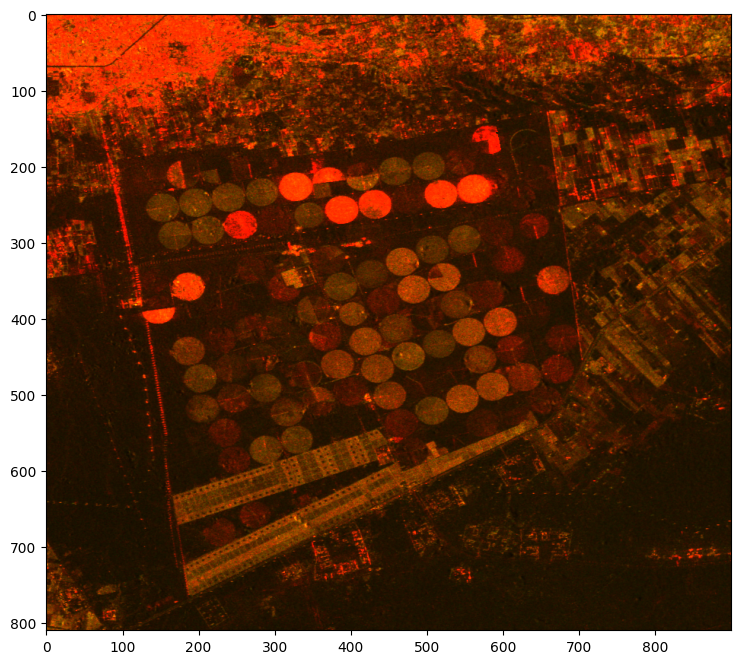

In [65]:
plt.figure(figsize = (16,8))
plt.imshow(ds_im)

## Configure JERS SAR Mosaic Data

Now we'll load the JERS SAR Mosaic. To do this, we have to set the data configuration as per the cell below. The configuration is set as a dictionary object (`dict`) in Python.

We can use the [product definition](https://explorer.digitalearth.africa/products/jers_sar_mosaic#definition-doc) on Digital Earth Africa explorer to help build the dictionary.

In [66]:
jers_config = {
    "jers_sar_mosaic": {
        "assets": {
            "*": {
                "data_type": "uint16",
                "nodata": 0,
                "unit": "1",
            },
            "mask": {
                "data_type": "uint8",
                "nodata": 0,
                "unit": "1",
            },
        },
    }
}

Create a query and return items for JERS SAR Mosaic.

In [67]:
# Set the STAC collections
collections = ["jers_sar_mosaic"]

# Build a query with the set parameters
query = catalog.search(
    bbox=bbox, collections=collections, datetime="1996"
)

# Search the STAC catalog for all items matching the query
items = list(query.items())
print(f"Found: {len(items):d} datasets")

Found: 1 datasets


Next, we use `stac_load()` to bring in the JERS SAR Mosaic data.

In [68]:
ds_jers = stac_load(
    items,
    bands=("hh", "mask"),
    crs=crs,
    chunks={},
    groupby="solar_day",
    stac_cfg=jers_config,
    bbox=bbox,
)

# View the Xarray Dataset
ds_jers

<xarray.Dataset> Size: 2MB
Dimensions:      (latitude: 810, longitude: 900, time: 1)
Coordinates:
  * latitude     (latitude) float64 6kB 30.55 30.55 30.55 ... 30.37 30.37 30.37
  * longitude    (longitude) float64 7kB 31.9 31.9 31.9 31.9 ... 32.1 32.1 32.1
    spatial_ref  int32 4B 4326
  * time         (time) datetime64[ns] 8B 1996-01-01
Data variables:
    hh           (time, latitude, longitude) uint16 1MB dask.array<chunksize=(1, 810, 900), meta=np.ndarray>
    mask         (time, latitude, longitude) uint8 729kB dask.array<chunksize=(1, 810, 900), meta=np.ndarray>

The cell below converts the digital number (DN) values in the JERS SAR Mosaic dataset to decidel (db) values. Further information on conversion is available [from JAXA](https://www.eorc.jaxa.jp/ALOS/en/dataset/pdf/DatasetDescription_JERS-1_Mosaic_ver200.pdf).

In [69]:
ds_jers['hh_db'] =  10 * np.log10(ds_jers.hh.where(ds_jers.mask.isin([50,255]))**2) - 84.66

Finally, we plot all JERS values for the year 1996.

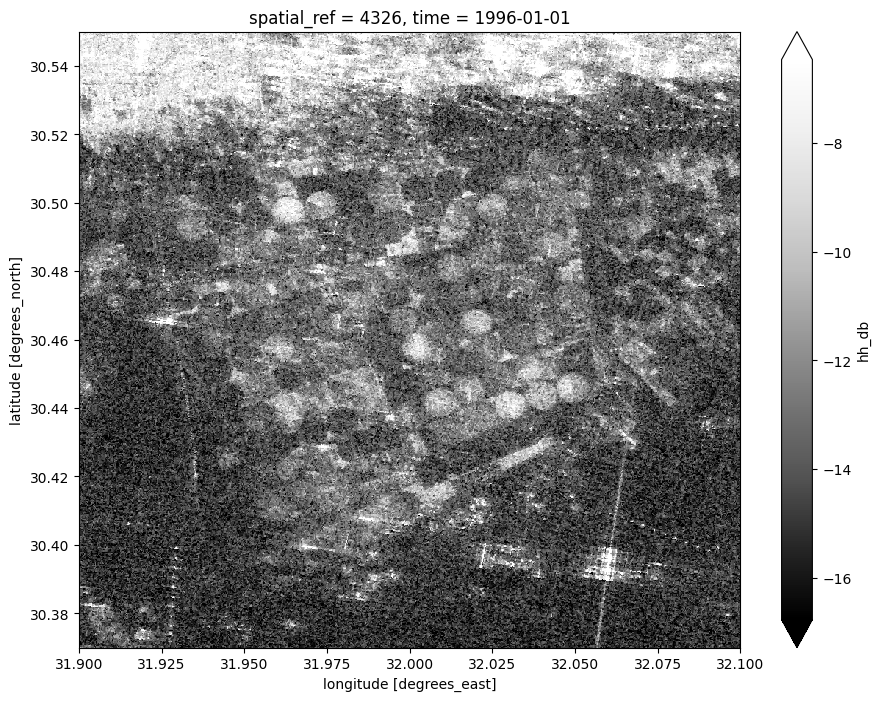

In [70]:
# Plot all VH observations for the year
ds_jers.hh_db.plot(cmap="Greys_r", robust=True,size=8);

## Conclusion and next steps

This notebook has demonstrating loading Digital Earth Africa SAR data. You could adapt these processes to Digital Earth Africa products and services of your interest.

---

## Additional information

<b> License </b> The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0).

Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

<b> Contact </b> If you need assistance, please post a question on the [DE Africa Slack channel](https://digitalearthafrica.slack.com/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).

If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Last Tested:**

In [71]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2025-04-28'